# Aerobic Decoupling

https://www.trainingpeaks.com/blog/aerobic-endurance-and-decoupling/#:~:text=Decoupling%20rate%20is%203.8%25.,%25%20to%20more%20than%2011%25.

http://alancouzens.blogspot.com/2009/10/science-of-decoupling.html

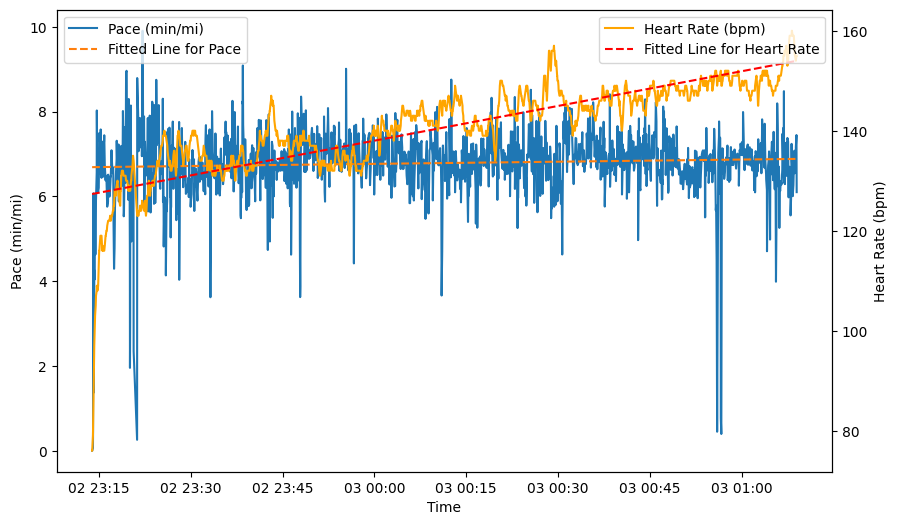

pace: 2.8151316568354117e-05
HR: 0.00385535142722462
(0.0008828437454357264, 0.011434360978433927)
Your aerobic decoupling is 8.7%. Good! Your aerobic decoupling is within an acceptable range (<= 10%). You have a decent level of aerobic fitness and pacing ability.


In [102]:
import gpxpy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as mod_datetime
from sklearn.linear_model import LinearRegression


def replace_tzinfo(dt):
    """ Fix TZ issue, as noted https://github.com/tkrajina/gpxpy/issues/209"""
    return dt.replace(tzinfo=mod_datetime.timezone(dt.utcoffset()))

def parse_gpx_file(gpx_file):
    # Parse the GPX file
    with open(gpx_file, 'r') as f:
        gpx = gpxpy.parse(f)
    
    # Extract data points (timestamp, heart rate, and distance)
    data = []
    distance = 0.0
    for track in gpx.tracks:
        for segment in track.segments:
            for i, point in enumerate(segment.points):
                if i > 0:
                    distance += segment.points[i].distance_3d(segment.points[i-1])
                
                # Extract heart rate from extensions
                heart_rate = None
                for ext in list(point.extensions):
                    for i in list(ext):
                        if i.tag =='{http://www.garmin.com/xmlschemas/TrackPointExtension/v1}hr':
                            heart_rate = float(i.text)
                            break
            
                data.append((replace_tzinfo(point.time), heart_rate, distance))
    
    # Create a DataFrame from the data
    df = pd.DataFrame(data, columns=['timestamp', 'heart_rate', 'distance'])
    
    # Calculate pace (minutes per mile)
    df['pace'] = df['distance'].diff() / (df['timestamp'].diff().dt.total_seconds() / 60) / 1609.344 * 60
    df['pace'] = df['pace'].replace([np.inf, -np.inf], np.nan).fillna(0)
    
    return df


def calculate_slopes(df):
    # Convert timestamps to numerical values (e.g., seconds since the first timestamp)
    time_numerical = (df['timestamp'] - df['timestamp'].iloc[0]).dt.total_seconds().values
    
    # Get the first and last time values
    x1 = time_numerical[0]
    x2 = time_numerical[-1]
    
    # Get the first and last pace values
    pace_y1 = df['pace'].iloc[0]
    pace_y2 = df['pace'].iloc[-1]
    
    # Calculate the slope for pace
    pace_slope = (pace_y2 - pace_y1) / (x2 - x1)
    
    # Get the first and last heart rate values
    heart_rate_y1 = df['heart_rate'].iloc[0]
    heart_rate_y2 = df['heart_rate'].iloc[-1]
    
    # Calculate the slope for heart rate
    heart_rate_slope = (heart_rate_y2 - heart_rate_y1) / (x2 - x1)
    
    return pace_slope, heart_rate_slope

# You can call the function with appropriate data to get the slopes.
# For example:
# pace_slope, heart_rate_slope = calculate_slopes(df)
# print("Slope of the line for pace:", pace_slope)
# print("Slope of the line for heart rate:", heart_rate_slope)


def plot_data_4(df):
    # Convert timestamps to numerical values (e.g., seconds since the first timestamp)
    time_numerical = (df['timestamp'] - df['timestamp'].iloc[0]).dt.total_seconds().values.reshape(-1, 1)
    
    # Create a linear regression model for pace
    pace_model = LinearRegression()
    pace_model.fit(time_numerical, df['pace'])
    predicted_pace = pace_model.predict(time_numerical)
    
    # Create a linear regression model for heart rate
    heart_rate_model = LinearRegression()
    heart_rate_model.fit(time_numerical, df['heart_rate'])
    predicted_heart_rate = heart_rate_model.predict(time_numerical)
    
    # Plot pace and its linear regression on the primary y-axis
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.plot(df['timestamp'], df['pace'], label='Pace (min/mi)')
    ax1.plot(df['timestamp'], predicted_pace, label='Fitted Line for Pace', linestyle='--')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Pace (min/mi)')
    ax1.legend(loc='upper left')
    
    # Plot heart rate and its linear regression on the secondary y-axis
    ax2 = ax1.twinx()
    ax2.plot(df['timestamp'], df['heart_rate'], color='orange', label='Heart Rate (bpm)')
    ax2.plot(df['timestamp'], predicted_heart_rate, color='red', label='Fitted Line for Heart Rate', linestyle='--')
    ax2.set_ylabel('Heart Rate (bpm)')
    ax2.legend(loc='upper right')
    
    plt.show()
    
    print(f"pace: {pace_model.coef_[0]}\nHR: {heart_rate_model.coef_[0]}")

# You can call the function with appropriate data to see the plot.
# For example: plot_data(df)



def fit_line_to_heart_rate(df):
    # Convert timestamps to numerical values (e.g., seconds since the first timestamp)
    time_numerical = (df['timestamp'] - df['timestamp'].iloc[0]).dt.total_seconds().values.reshape(-1, 1)
    
    # Extract heart rate values
    heart_rate = df['heart_rate'].values
    
    # Create a linear regression model
    model = LinearRegression()
    
    # Fit the model to the data
    model.fit(time_numerical, heart_rate)
    
    # Get the slope (m) and intercept (b) of the fitted line
    slope = model.coef_[0]
    intercept = model.intercept_
    
    # Calculate the predicted heart rate values using the fitted line
    predicted_heart_rate = model.predict(time_numerical)
    
    # Plot the actual heart rate data
    plt.plot(df['timestamp'], heart_rate, label='Actual Heart Rate (bpm)')
    
    # Plot the fitted line
    plt.plot(df['timestamp'], predicted_heart_rate, label='Fitted Line (y = {:.2f}x + {:.2f})'.format(slope, intercept), linestyle='--')
    
    # Set labels and show legend
    plt.xlabel('Time')
    plt.ylabel('Heart Rate (bpm)')
    plt.legend()
    
    # Show the plot
    plt.show()


def calculate_aerobic_decoupling_df(df):
    
    # Calculate cumulative distance (kilometers)
    df['cumulative_distance'] = df['distance'] / 1000
    
    # Calculate the midpoint of the run (distance)
    midpoint = df['cumulative_distance'].max() / 2
    
    # Check if the run duration is long enough (e.g., at least 60 minutes)
    duration_minutes = (df['timestamp'].max() - df['timestamp'].min()).total_seconds() / 60
    if duration_minutes < 60:
        print("The run duration may be too short for aerobic decoupling analysis.")
    
    # Check if the run contains intervals or is too unevenly paced
    pace_std = df['pace'].std()
    if pace_std > 1.0:  # Threshold for uneven pacing (e.g., 1 minute per kilometer)
        print("The run may be too unevenly paced for aerobic decoupling analysis.")
    
    # Calculate the average pace and average heart rate for the first and second halves
    first_half = df[df['cumulative_distance'] <= midpoint]
    second_half = df[df['cumulative_distance'] > midpoint]
    
    avg_pace_first_half = first_half['pace'].mean()
    avg_hr_first_half = first_half['heart_rate'].mean()
    
    
    avg_pace_second_half = second_half['pace'].mean()
    avg_hr_second_half = second_half['heart_rate'].mean()
    
    # Calculate the heart rate-to-pace ratio for both halves
    hr_to_pace_ratio_first_half = avg_hr_first_half / avg_pace_first_half
    hr_to_pace_ratio_second_half = avg_hr_second_half / avg_pace_second_half

    
    # Calculate aerobic decoupling
    aerobic_decoupling = ((hr_to_pace_ratio_second_half / hr_to_pace_ratio_first_half) - 1) * 100
    
    return aerobic_decoupling

def interpret_aerobic_decoupling(aerobic_decoupling):
    """ChatGPT selected all thes ranges"""
    current = f"Your aerobic decoupling is {round(aerobic_decoupling, 1)}%."
    if aerobic_decoupling is None:
        return "Aerobic decoupling could not be calculated."
    elif aerobic_decoupling <= 5:
        return f"{current} Excellent! Your aerobic decoupling is within the optimal range (<= 5%). This indicates good aerobic fitness and pacing ability."
    elif aerobic_decoupling <= 10:
        return f"{current} Good! Your aerobic decoupling is within an acceptable range (<= 10%). You have a decent level of aerobic fitness and pacing ability."
    elif aerobic_decoupling <= 15:
        return f"{current} Fair. Your aerobic decoupling is slightly elevated (> 10% and <= 15%). There may be room for improvement in aerobic fitness or pacing."
    else:
        return f"{current} Poor. Your aerobic decoupling is high (> 15%). This suggests potential issues with aerobic fitness or pacing. Consider evaluating your training and making adjustments."


# Example usage
gpx_file = 'Afternoon_Run.gpx'
df = parse_gpx_file(gpx_file)
result = calculate_aerobic_decoupling_df(df)
plot_data_4(df)
print(calculate_slopes(df))
print(interpret_aerobic_decoupling(result))
